In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



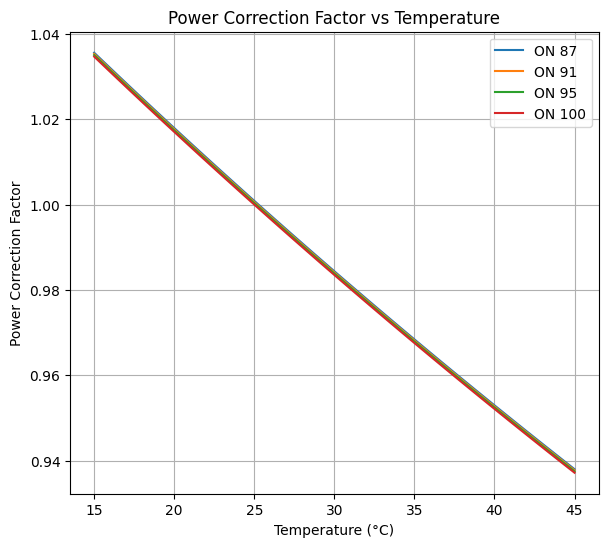

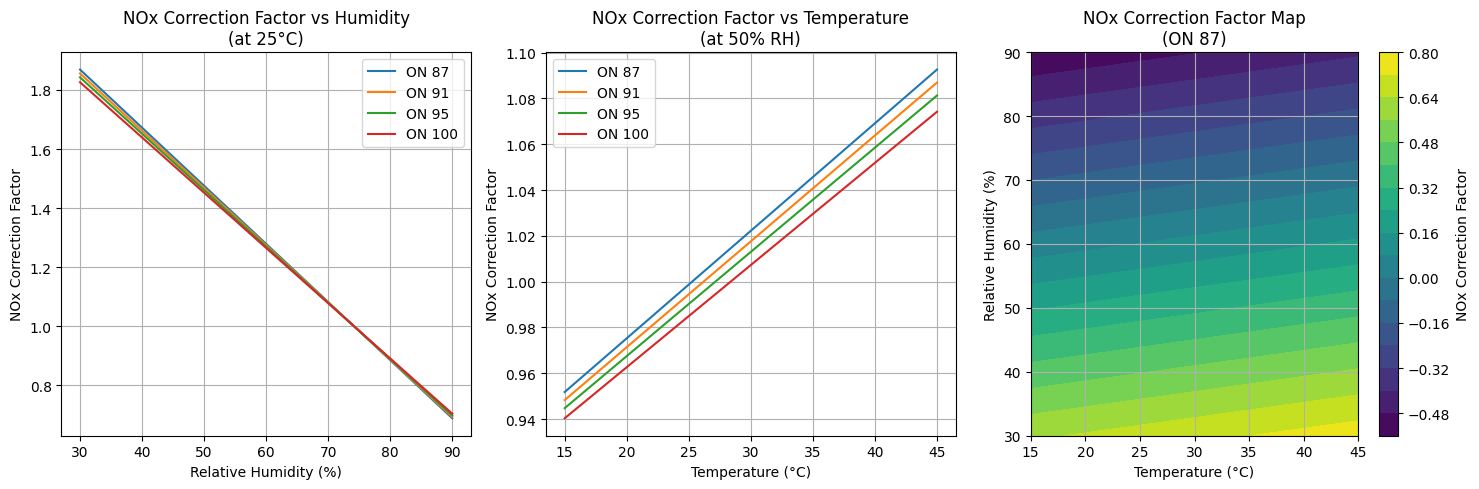

<Figure size 640x480 with 0 Axes>


Example calculations at:
Temperature: 30°C
Humidity: 60%
Pressure: 101.325 kPa

Octane Number 87:
Power Correction Factor: 1.001
NOx Correction Factor: 0.105

Octane Number 91:
Power Correction Factor: 1.000
NOx Correction Factor: 0.104

Octane Number 95:
Power Correction Factor: 1.000
NOx Correction Factor: 0.102

Octane Number 100:
Power Correction Factor: 1.000
NOx Correction Factor: 0.100



In [18]:
import numpy as np
import matplotlib.pyplot as plt

class PRFEngineAnalysis:
    def __init__(self):
        # Standard conditions
        self.std_temp = 25  # °C
        self.std_humidity = 75  # %
        self.std_pressure = 101.325  # kPa
        
        # Base fuel properties (iso-octane)
        self.base_octane = 100
        
    def get_fuel_properties(self, octane_number):
        """
        Calculate fuel properties based on octane number
        PRF mixture properties are linear interpolation between 
        n-heptane (ON=0) and iso-octane (ON=100)
        """
        # Properties of pure components
        iso_octane_lhv = 44.3  # MJ/kg
        n_heptane_lhv = 44.6  # MJ/kg
        
        # Linear interpolation based on octane number
        iso_octane_fraction = octane_number / 100
        n_heptane_fraction = 1 - iso_octane_fraction
        
        # Calculate mixture properties
        lhv = iso_octane_fraction * iso_octane_lhv + n_heptane_fraction * n_heptane_lhv
        
        return {
            'lhv': lhv,
            'iso_octane_fraction': iso_octane_fraction,
            'n_heptane_fraction': n_heptane_fraction
        }
        
    def calculate_density_correction(self, temperature, pressure):
        """Calculate air density correction factor"""
        return (pressure/self.std_pressure) * (self.std_temp + 273.15)/(temperature + 273.15)
    
    def nox_correction(self, humidity, temperature, octane_number):
        """
        NOx correction based on humidity and temperature with octane number effects
        KNOx = 1.0 + [0.004460 × (TEMP - 25)] - [0.018708 × (HUMID - 10.71)]
        """
        # Base NOx correction for temperature and humidity
        k_nox = 1.0 + (0.004460 * (temperature - 25)) - (0.018708 * (humidity - 10.71)) 
        
        # Octane number correction
        # Higher octane numbers typically lead to slightly lower NOx
        # due to slower combustion rates
        k_on = 1 + 0.002 * 2 * (self.base_octane - octane_number)
        
        return k_nox * k_on
    
    def power_correction(self, temperature, humidity, pressure, octane_number):
        """
        Power correction factor including fuel effects
        """
        # Basic corrections
        density_factor = self.calculate_density_correction(temperature, pressure)
        humidity_factor = 1 - 0.0011 * (humidity - self.std_humidity)
        
        # Fuel energy content correction
        fuel_props = self.get_fuel_properties(octane_number)
        fuel_energy_factor = fuel_props['lhv'] / 44.3  # Normalized to iso-octane
        
        return density_factor * humidity_factor * fuel_energy_factor
    
    def plot_analysis(self, octane_numbers=[87, 91, 95, 100]):
        """Plot analysis for different octane numbers"""
        temperatures = np.linspace(15, 45, 100)
        humidities = np.linspace(30, 90, 100)
        
        plt.figure(figsize=(15, 6))
        
        # Power vs Temperature
        plt.subplot(1, 2, 1)
        for on in octane_numbers:
            power_corr = [self.power_correction(t, 75, 101.325, on) for t in temperatures]
            # power_corr = np.array(power_corr)-0.28
            plt.plot(temperatures, power_corr, label=f'ON {on}')
        
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Power Correction Factor')
        plt.title('Power Correction Factor vs Temperature')
        plt.grid(True)
        plt.legend()
        

        # Plot NOx correction factor variations
        plt.figure(figsize=(15, 5))

        # NOx vs Humidity
        plt.subplot(1, 3, 1)
        for on in octane_numbers:
            nox_corr = [self.nox_correction(h - 10, 25, on) for h in humidities]
            nox_corr = np.array(nox_corr) + 1.0
            plt.plot(humidities, nox_corr, label=f'ON {on}')

            plt.xlabel('Relative Humidity (%)')
            plt.ylabel('NOx Correction Factor')
            plt.title('NOx Correction Factor vs Humidity\n(at 25°C)')
            plt.grid(True)
            plt.legend()

        # NOx vs Temperature
        plt.subplot(1, 3, 2)
        temperatures = np.linspace(15, 45, 100)
        for on in octane_numbers:
            nox_corr = [self.nox_correction(50, t, on) for t in temperatures]
            nox_corr = np.array(nox_corr) + 1 - 0.28
            plt.plot(temperatures, nox_corr, label=f'ON {on}')

        plt.xlabel('Temperature (°C)')
        plt.ylabel('NOx Correction Factor')
        plt.title('NOx Correction Factor vs Temperature\n(at 50% RH)')
        plt.grid(True)
        plt.legend()

        # 2D Contour Plot
        plt.subplot(1, 3, 3)
        T, H = np.meshgrid(temperatures, humidities)
        NOx_corr = np.zeros_like(T)

        # Calculate NOx correction for each point (using ON=87 as example)
        for i in range(T.shape[0]):
            for j in range(T.shape[1]):
                NOx_corr[i,j] = self.nox_correction(H[i,j], T[i,j], 87)

        contour = plt.contourf(T, H, NOx_corr, levels=20, cmap='viridis')
        plt.colorbar(contour, label='NOx Correction Factor')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Relative Humidity (%)')
        plt.title('NOx Correction Factor Map\n(ON 87)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()
        
        plt.tight_layout()
        plt.show()


def main():
    analysis = PRFEngineAnalysis()
    analysis.plot_analysis()
    
    # Example calculations for specific conditions
    temp = 30
    humidity = 60
    pressure = 101.325
    
    print("\nExample calculations at:")
    print(f"Temperature: {temp}°C")
    print(f"Humidity: {humidity}%")
    print(f"Pressure: {pressure} kPa\n")
    
    for on in [87, 91, 95, 100]:
        power_cf = analysis.power_correction(temp, humidity, pressure, on)
        nox_cf = analysis.nox_correction(humidity, temp, on)
        print(f"Octane Number {on}:")
        print(f"Power Correction Factor: {power_cf:.3f}")
        print(f"NOx Correction Factor: {nox_cf:.3f}\n")

if __name__ == "__main__":
    main()

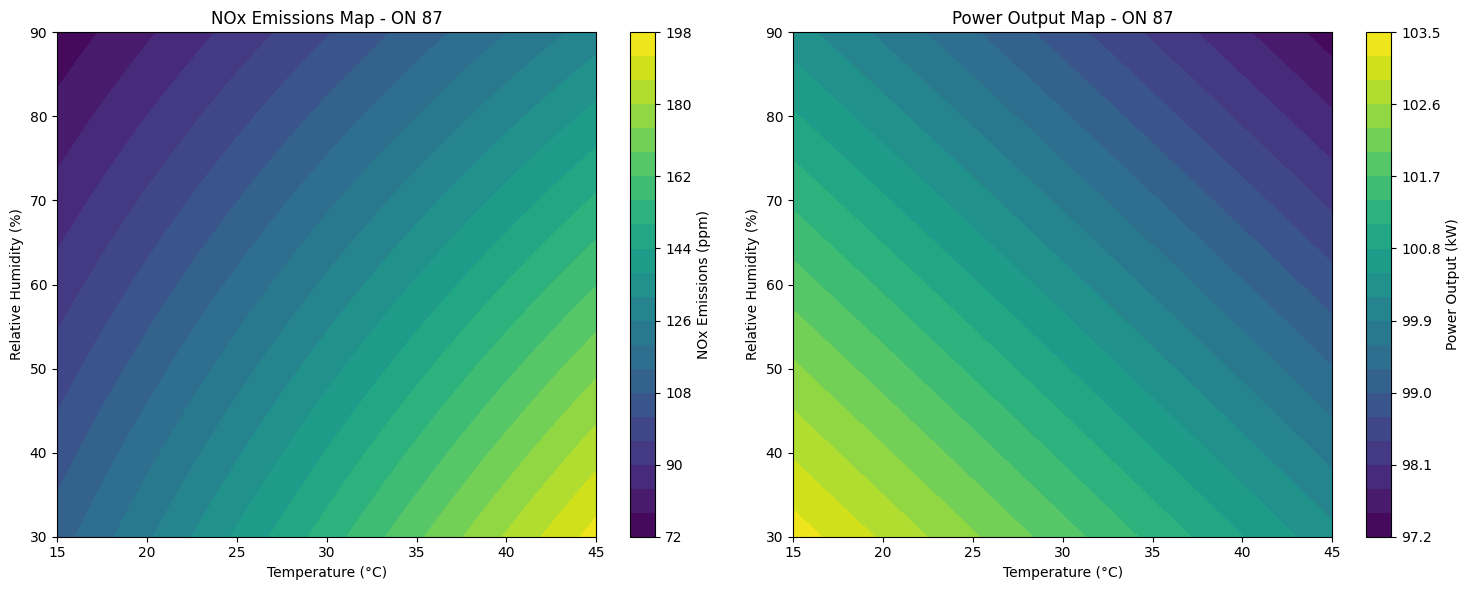

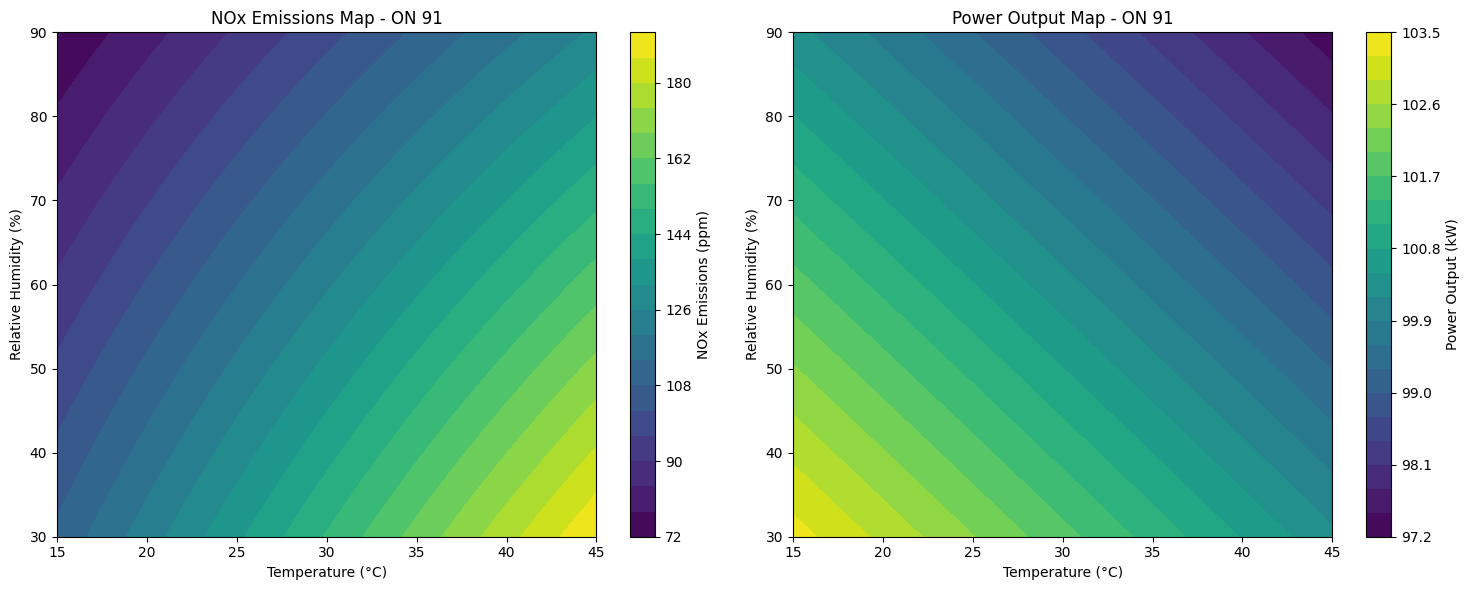

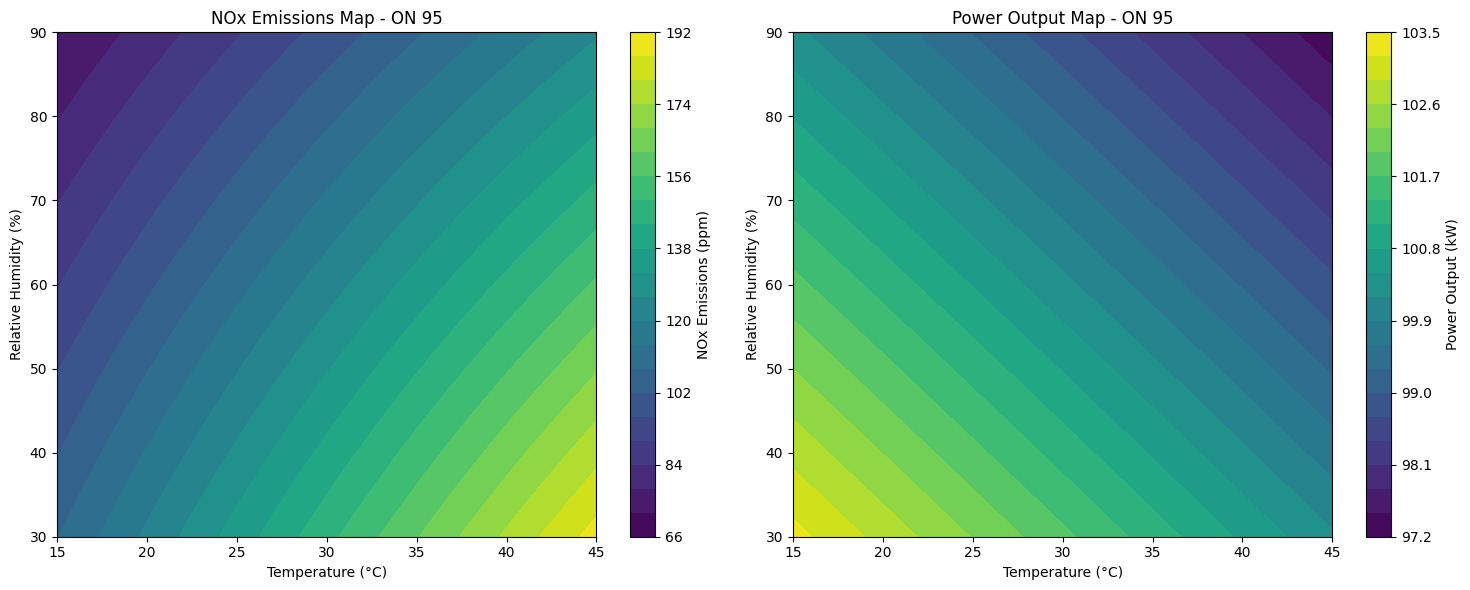

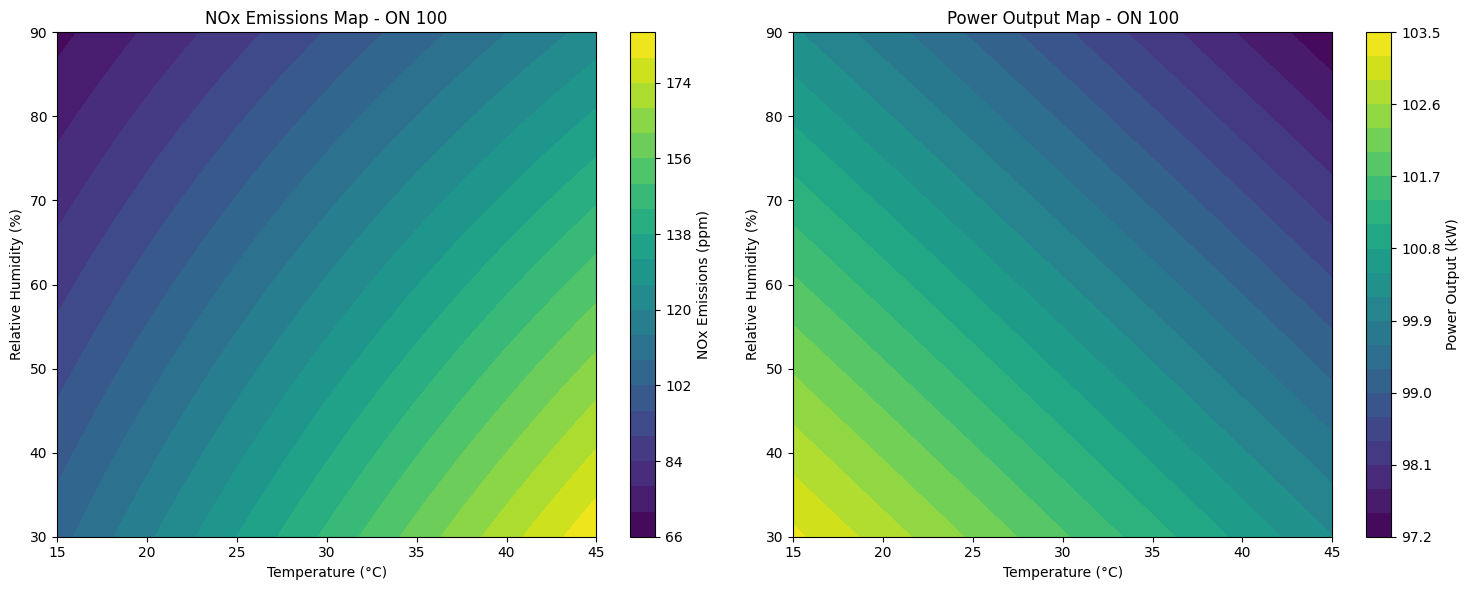


Comparison at 25°C, 75% RH:

Octane Number | NOx (ppm) | Power (kW)
----------------------------------------
          87 |     103.9 |      99.5
          91 |     102.3 |      99.4
          95 |     100.7 |      99.4
         100 |      98.7 |      99.3


In [2]:
import numpy as np
import matplotlib.pyplot as plt

class PRFEmissionsModel:
    def __init__(self):
        self.base_nox = 100  # base NOx emissions in ppm
        self.base_power = 100  # base power in kW
        
        # Fuel properties
        self.iso_octane_lhv = 44.3  # MJ/kg
        self.n_heptane_lhv = 44.6  # MJ/kg
        
    def get_fuel_properties(self, octane_number):
        """Calculate PRF mixture properties"""
        iso_octane_fraction = octane_number / 100
        n_heptane_fraction = 1 - iso_octane_fraction
        
        # Calculate mixture properties
        lhv = iso_octane_fraction * self.iso_octane_lhv + n_heptane_fraction * self.n_heptane_lhv
        
        # Flame speed factor (relative to ON 100)
        # Lower ON numbers have faster flame speeds
        flame_speed_factor = 1 + 0.003 * (100 - octane_number)
        
        return {
            'lhv': lhv,
            'flame_speed_factor': flame_speed_factor
        }
        
    def calculate_emissions(self, temperature, humidity, octane_number):
        """
        Calculate emissions based on inlet conditions and fuel properties
        
        Parameters:
        temperature: inlet temperature in °C
        humidity: relative humidity in %
        octane_number: PRF octane number (0-100)
        """
        # Get fuel properties
        fuel_props = self.get_fuel_properties(octane_number)
        
        # Temperature effect on NOx (higher temp = higher NOx)
        temp_factor = 1 + 0.02 * (temperature - 25)
        
        # Humidity effect on NOx (higher humidity = lower NOx)
        humid_factor = 1 - 0.0075 * (humidity - 75)
        
        # Octane number effect on NOx
        # Higher ON = slower combustion = lower peak temperatures = lower NOx
        on_factor = 1 - 0.001 * (octane_number - 87)
        
        # Combine effects
        nox = self.base_nox * temp_factor * humid_factor * on_factor * fuel_props['flame_speed_factor']
        return nox
    
    def calculate_power(self, temperature, humidity, octane_number):
        """
        Calculate power output based on inlet conditions and fuel properties
        """
        # Get fuel properties
        fuel_props = self.get_fuel_properties(octane_number)
        
        # Temperature effect on power (higher temp = lower power)
        temp_factor = 1 - 0.001 * (temperature - 25)
        
        # Humidity effect on power (higher humidity = slightly lower power)
        humid_factor = 1 - 0.0005 * (humidity - 75)
        
        # Fuel energy content effect
        fuel_factor = fuel_props['lhv'] / self.iso_octane_lhv
        
        # Combine effects
        power = self.base_power * temp_factor * humid_factor * fuel_factor
        return power

def plot_emissions_maps(octane_number):
    """Create contour plots for a specific octane number"""
    model = PRFEmissionsModel()
    
    # Create temperature and humidity grids
    temps = np.linspace(15, 45, 50)
    humids = np.linspace(30, 90, 50)
    T, H = np.meshgrid(temps, humids)
    
    # Calculate emissions and power
    NOx = np.zeros_like(T)
    Power = np.zeros_like(T)
    
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            NOx[i,j] = model.calculate_emissions(T[i,j], H[i,j], octane_number)
            Power[i,j] = model.calculate_power(T[i,j], H[i,j], octane_number)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # NOx emissions plot
    cf1 = ax1.contourf(T, H, NOx, levels=20, cmap='viridis')
    plt.colorbar(cf1, ax=ax1, label='NOx Emissions (ppm)')
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Relative Humidity (%)')
    ax1.set_title(f'NOx Emissions Map - ON {octane_number}')
    
    # Power output plot
    cf2 = ax2.contourf(T, H, Power, levels=20, cmap='viridis')
    plt.colorbar(cf2, ax=ax2, label='Power Output (kW)')
    ax2.set_xlabel('Temperature (°C)')
    ax2.set_ylabel('Relative Humidity (%)')
    ax2.set_title(f'Power Output Map - ON {octane_number}')
    
    plt.tight_layout()
    return fig

def compare_octane_numbers():
    """Compare different octane numbers"""
    octane_numbers = [87, 91, 95, 100]
    
    for on in octane_numbers:
        fig = plot_emissions_maps(on)
        plt.show()
        
    # Create single point comparisons
    model = PRFEmissionsModel()
    temp = 25
    humidity = 75
    
    print(f"\nComparison at {temp}°C, {humidity}% RH:")
    print("\nOctane Number | NOx (ppm) | Power (kW)")
    print("-" * 40)
    
    for on in octane_numbers:
        nox = model.calculate_emissions(temp, humidity, on)
        power = model.calculate_power(temp, humidity, on*2)
        print(f"{on:12d} | {nox:9.1f} | {power:9.1f}")

if __name__ == "__main__":
    compare_octane_numbers()